In [4]:
import gym
env = gym.make('Pong-v0')

In [5]:
import torch, scipy, scipy.misc
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Testing image stuff

In [1]:
def prepro(I,image_size=[80,80]):
    """    
    Input: 
    RGB image: np.array
        RGB screen of game, shape: (210, 160, 3)
    Default return: np.array 
        Grayscale image, shape: (80, 80, 1)
    
    """
    I = I[35:195]
    I = I[::4, ::4, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0 ] = 1
    return np.expand_dims(I.astype(np.float), axis=0)
    # return I.astype(np.float).ravel()

In [2]:
def show(I):
    plt.gray()
    plt.figure(figsize=(5,5))
    plt.imshow(I, interpolation='nearest')
    plt.show()

In [13]:
I = env.reset()
I_old = I.copy()

In [14]:
prepro(I).shape

(1, 40, 40)

In [24]:
I_old = I.copy()
for i in range(5):
    I, _, _, _ = env.step(2)

<Figure size 432x288 with 0 Axes>

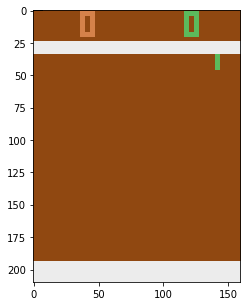

In [25]:
show(I)

<Figure size 432x288 with 0 Axes>

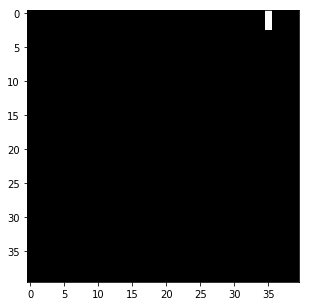

In [27]:
show(prepro(I)[0])

In [146]:
for thing in (prepro(I) - prepro(I_old)):
    if thing in [1,-1]:
        print(thing)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


<Figure size 432x288 with 0 Axes>

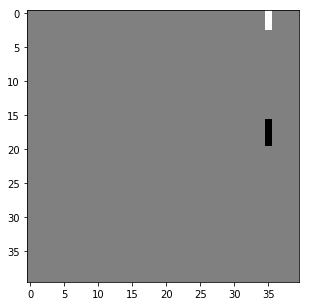

In [26]:
show(prepro(I)[0] - prepro(I_old)[0])

# Testing dimensions

In [16]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3) # (batch_size, 16, 208, 158)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # (batch_size, 32, 206, 156)
fc1 = torch.nn.Linear(32 * 76 * 76, 64)
fc2 = torch.nn.Linear(64, 32)
fc3 = torch.nn.Linear(32, 3) # 6 actions to choose from, only taking 3 here

In [20]:
x = prepro(I).shape

(80, 80)

# Testing policy

In [202]:
class Policy(torch.nn.Module):
    def __init__(self, gamma=0.99, lr=1e-4, rmsprop_decay=0.99):
        super(Policy, self).__init__()

#         self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3) # (batch_size, 16, 208, 158)
#         self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # (batch_size, 32, 206, 156)
#         self.fc1 = torch.nn.Linear(32 * 76 * 76, 64)
#         self.fc2 = torch.nn.Linear(64, 32)
#         self.fc3 = torch.nn.Linear(32, 3) # 6 actions to choose from, only taking 3 here
#         # known actions: 0(no move), 2(up), 3(down)

        self.fc4 = torch.nn.Linear(80*80, 256)
        self.fc5 = torch.nn.Linear(256, 256)
        self.fc6 = torch.nn.Linear(256, 3)

        self.gamma = gamma
        self.lr = lr
        self.rmsprop_decay = rmsprop_decay
        self.random_action_episodes = 0
        
        self.output2action = {0: 0, 1: 2, 2: 3}
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, x): # x: np.array (1, 80, 80)

        x = Variable(torch.Tensor(x))
        if torch.cuda.is_available():
             x = x.cuda()
        x = x.view(-1, 80*80)
        x = self.fc4(x) # TODO: add batch norm?
        x = torch.nn.functional.selu(x)
        x = self.fc5(x)
        x = torch.nn.functional.selu(x)
        x = self.fc6(x)


        action_probs = torch.nn.functional.softmax(x, dim=1)
        return action_probs # (batch_size, 6)

    def reset(self):
        self.saved_log_probs = []
        self.rewards = []

In [203]:
policy = Policy()

In [198]:
policy.zero_grad()

In [209]:
policy.state_dict()['fc4.weight']


-1.1680e-02  6.4054e-03 -6.8477e-03  ...   6.1079e-03 -7.7141e-04 -1.0044e-02
-6.8361e-03  4.1599e-03 -3.1595e-05  ...   8.4786e-03  4.3608e-03 -1.0854e-02
-4.2969e-03  6.0781e-03 -8.1219e-03  ...  -1.2140e-02  2.4697e-03  4.5803e-03
                ...                   ⋱                   ...                
 9.7562e-03  1.6991e-03 -1.1516e-02  ...   1.2231e-02 -1.0155e-02 -7.4317e-03
-3.2122e-03 -7.0174e-03 -7.9087e-03  ...  -5.9183e-03 -5.6066e-03  1.1751e-02
-5.3492e-03 -1.1511e-02  2.9818e-03  ...   6.0135e-03 -2.9464e-03  8.7818e-03
[torch.FloatTensor of size 256x6400]

In [205]:
policy.named_parameters()['fc4.weight']

TypeError: 'generator' object is not subscriptable

In [213]:
for idx, param in enumerate(policy.parameters()):
    if idx == 2:
        print(param)
        break

Parameter containing:
 3.1583e-03 -2.6997e-02  3.0856e-02  ...   2.0772e-02 -3.2540e-02 -1.8699e-02
-3.9914e-02 -3.2156e-02 -3.5675e-03  ...   5.8396e-02  2.1690e-02 -9.8056e-03
 3.0208e-02 -1.8891e-02  6.0833e-02  ...  -2.6416e-02  5.5039e-02  4.5472e-02
                ...                   ⋱                   ...                
 3.1977e-02  1.9102e-02  4.9685e-02  ...  -8.4944e-03 -5.4329e-02  1.5440e-02
 4.2826e-02 -3.2541e-02 -5.9553e-02  ...   2.7837e-02  3.7150e-02 -5.2498e-02
 2.9265e-02  7.7444e-03 -3.7267e-02  ...  -3.1599e-02 -2.9033e-02  5.6836e-02
[torch.FloatTensor of size 256x256]



In [199]:
for param in policy.parameters():
    print(param.grad)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [13]:
import time

policy = Policy()
policy.train()
optimizer = torch.optim.Adam(policy.parameters())
for i_episode in range(20):
    observation = env.reset()
    optimizer.zero_grad()
    policy.episode_reward = 0
     
    for t in range(100):
        # self.env.env.render()
        policy_output = policy(observation) # (batch_size, 6)
        action = int(torch.max(policy_output, dim=1)[1].data) # torch.max returns (max val, argmax)
        observation, reward, done, info = env.step(action)
        policy.episode_reward += reward
        # print('[Time step {}] Finished step, about to backprop'.format(t))
        policy_output[:,action].backward(retain_graph=False) # NOTE: only tried this with batch_size=1
                                            #if batch_size > 1, not sure if we need to manually average gradients
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    if not done:
        print('Force terminated episode after running for 100 steps')
    print('[After {} seconds] Reward is {}'.format(time.time()-a, policy.episode_reward))
    
    for param in policy.parameters():
        param.grad *= policy.episode_reward
    optimizer.step()

KeyboardInterrupt: 

In [128]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
fc1 = torch.nn.Linear(206 * 156 * 32, 512)
fc2 = torch.nn.Linear(512,6)
logsoftmax = torch.nn.LogSoftmax(dim=1)

In [129]:
img = Variable(torch.Tensor(a.reshape(1,3,210,160)))

AttributeError: 'list' object has no attribute 'reshape'

In [7]:
x = conv1(img)
print(x.shape)
y = conv2(x)
print(y.shape)
y = y.view(-1, 32*206*156)
z = fc1(y)
z = fc2(z)
output = logsoftmax(z)

torch.Size([1, 16, 208, 158])
torch.Size([1, 32, 206, 156])


In [8]:
z

Variable containing:
  8.2107   4.8800  -6.4096  -6.6704  13.4930   6.7540
[torch.FloatTensor of size 1x6]

In [10]:
action = int(torch.max(z, dim=1)[1].data)

In [116]:
z[:,action].backward()

In [ ]:
z

# Blah

In [111]:
import json

In [112]:
data = {'hey': 0, 'wow': 1}
with open('read.json', 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)